# Factorización de Semiprimos con Algoritmo de Shor
## Análisis Estadístico en Simulación Cuántica Local

**Objetivo:** Estudiar el comportamiento probabilístico del algoritmo de Shor para factorizar semiprimos, analizando:
- Shots necesarios para viabilidad
- Tasa de éxito vs tamaño del número (n bits)
- Recursos cuánticos requeridos
- Probabilidad de éxito acumulada
- Distribución de resultados (campana de Gauss)

In [1]:
# Instalación de dependencias
!pip -q install pandas numpy matplotlib tqdm scipy
!pip -q install qiskit qiskit-aer


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from fractions import Fraction
from tqdm import tqdm
import os

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator

print("Simulador cuántico local configurado")
print(f"NumPy: {np.__version__}")

Simulador cuántico local configurado
NumPy: 2.4.1


In [3]:
# === CONFIGURACIÓN DEL EXPERIMENTO ===

# Rango de bits para semiprimos
BIT_RANGE = list(range(4, 13))  # 4 a 12 bits

# Shots por ejecución
M_SHOTS_LIST = [100, 500, 1024, 2048, 4096]

# Repeticiones por escenario
R = 50

# Semiprimos por cada tamaño
SEMIPRIMES_PER_SIZE = 5

# Directorio de datos
DATA_DIR = "datasets"
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Configuración:")
print(f"  Bits: {BIT_RANGE[0]} a {BIT_RANGE[-1]}")
print(f"  Shots: {M_SHOTS_LIST}")
print(f"  Repeticiones: {R}")

Configuración:
  Bits: 4 a 12
  Shots: [100, 500, 1024, 2048, 4096]
  Repeticiones: 50


## Generación de Semiprimos (sin sympy)

In [4]:
def is_prime(n: int) -> bool:
    """Test de primalidad sin sympy."""
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False
    for i in range(3, int(math.isqrt(n)) + 1, 2):
        if n % i == 0:
            return False
    return True

def generate_primes_in_range(min_val: int, max_val: int) -> list:
    """Genera lista de primos en un rango."""
    return [n for n in range(min_val, max_val + 1) if is_prime(n)]

def generate_semiprimes(n_bits: int, count: int) -> list:
    """Genera semiprimos de exactamente n_bits."""
    min_val = 2 ** (n_bits - 1)
    max_val = 2 ** n_bits - 1
    
    prime_max = int(math.isqrt(max_val)) + 1
    primes = generate_primes_in_range(2, prime_max)
    
    semiprimes = []
    for p in primes:
        for q in primes:
            if p <= q:
                N = p * q
                if min_val <= N <= max_val and p != q:
                    semiprimes.append((N, p, q))
    
    np.random.shuffle(semiprimes)
    return semiprimes[:count]

# Generar semiprimos
print("Generando semiprimos de prueba...")
test_semiprimes = {}
for n_bits in BIT_RANGE:
    test_semiprimes[n_bits] = generate_semiprimes(n_bits, SEMIPRIMES_PER_SIZE)
    if test_semiprimes[n_bits]:
        print(f"  {n_bits} bits: {len(test_semiprimes[n_bits])} semiprimos, ej: {test_semiprimes[n_bits][0]}")
    else:
        print(f"  {n_bits} bits: No se encontraron semiprimos")

Generando semiprimos de prueba...
  4 bits: No se encontraron semiprimos
  5 bits: No se encontraron semiprimos
  6 bits: 1 semiprimos, ej: (35, 5, 7)
  7 bits: 1 semiprimos, ej: (77, 7, 11)
  8 bits: 1 semiprimos, ej: (143, 11, 13)
  9 bits: 4 semiprimos, ej: (437, 19, 23)
  10 bits: 5 semiprimos, ej: (589, 19, 31)
  11 bits: 5 semiprimos, ej: (1517, 37, 41)
  12 bits: 5 semiprimos, ej: (2501, 41, 61)


## Algoritmo de Shor - Componentes Cuánticos

In [5]:
def qft_dagger(circuit: QuantumCircuit, n: int):
    """QFT inversa para n qubits."""
    for qubit in range(n // 2):
        circuit.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            circuit.cp(-np.pi / float(2 ** (j - m)), m, j)
        circuit.h(j)

def c_amod15(a: int, power: int) -> QuantumCircuit:
    """Multiplicación modular controlada para N=15."""
    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2, 13]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [7, 8]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

def shor_circuit_15(a: int, n_count: int = 8) -> QuantumCircuit:
    """Circuito de Shor para N=15."""
    qc = QuantumCircuit(n_count + 4, n_count)
    
    for q in range(n_count):
        qc.h(q)
    
    qc.x(n_count)
    
    for q in range(n_count):
        qc.append(c_amod15(a, 2**q), [q] + list(range(n_count, n_count + 4)))
    
    qft_dagger(qc, n_count)
    qc.measure(range(n_count), range(n_count))
    
    return qc

print("Componentes cuánticos definidos")

Componentes cuánticos definidos


In [6]:
def gcd(a: int, b: int) -> int:
    """Máximo común divisor."""
    while b:
        a, b = b, a % b
    return a

def mod_exp(base: int, exp: int, mod: int) -> int:
    """Exponenciación modular eficiente."""
    result = 1
    base = base % mod
    while exp > 0:
        if exp % 2 == 1:
            result = (result * base) % mod
        exp = exp >> 1
        base = (base * base) % mod
    return result

def create_general_qpe_circuit(N: int, a: int, n_count: int) -> QuantumCircuit:
    """Circuito QPE generalizado para encontrar período."""
    n_aux = max(4, N.bit_length())
    qc = QuantumCircuit(n_count + n_aux, n_count)
    
    # Superposición inicial
    for q in range(n_count):
        qc.h(q)
    
    # |1⟩ en registro auxiliar
    qc.x(n_count)
    
    # Rotaciones de fase controladas
    for q in range(n_count):
        power = 2 ** q
        phase_val = mod_exp(a, power, N)
        angle = 2 * np.pi * phase_val / (2 ** n_count)
        qc.cp(angle, q, n_count)
    
    # QFT inversa
    qft_dagger(qc, n_count)
    
    # Medición
    qc.measure(range(n_count), range(n_count))
    
    return qc

print("Funciones auxiliares definidas")

Funciones auxiliares definidas


## Algoritmo de Shor Completo

In [9]:
def find_period_quantum(N: int, a: int, shots: int) -> tuple:
    """Encuentra el período usando QPE."""
    t0 = time.time()
    
    n_count = max(4, 2 * N.bit_length())
    n_count = min(n_count, 12)  # Límite para simulación
    
    if N == 15:
        qc = shor_circuit_15(a, n_count)
    else:
        qc = create_general_qpe_circuit(N, a, n_count)
    
    # *** FIX: Decompose the circuit into basic gates ***
    qc_decomposed = qc.decompose()
    
    simulator = AerSimulator()
    job = simulator.run(qc_decomposed, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    elapsed = time.time() - t0
    qubits_used = qc.num_qubits
    
    # Procesar resultados
    for output, count in sorted(counts.items(), key=lambda x: -x[1]):
        decimal = int(output, 2)
        if decimal == 0:
            continue
        phase = decimal / (2 ** n_count)
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        
        if r > 1 and mod_exp(a, r, N) == 1:
            return r, True, elapsed, qubits_used
    
    return None, False, elapsed, qubits_used

def shor_factor(N: int, shots: int, max_attempts: int = 10) -> dict:
    """Ejecuta Shor para factorizar N."""
    t_start = time.time()
    qubits_used = 0
    
    # Caso trivial
    if N % 2 == 0:
        return {'success': True, 'factors': [2, N // 2], 'attempts': 0,
                'time': 0, 'qubits_used': 0, 'method': 'trivial_even'}
    
    for attempt in range(1, max_attempts + 1):
        a = np.random.randint(2, N - 1)
        
        g = gcd(a, N)
        if g > 1:
            return {'success': True, 'factors': sorted([g, N // g]), 'attempts': attempt,
                    'time': time.time() - t_start, 'qubits_used': 0, 'method': 'gcd_luck'}
        
        r, found, q_time, qubits = find_period_quantum(N, a, shots)
        qubits_used = qubits
        
        if found and r is not None and r % 2 == 0:
            x = mod_exp(a, r // 2, N)
            f1 = gcd(x - 1, N)
            f2 = gcd(x + 1, N)
            
            if 1 < f1 < N:
                return {'success': True, 'factors': sorted([f1, N // f1]),
                        'attempts': attempt, 'time': time.time() - t_start,
                        'qubits_used': qubits, 'method': 'quantum'}
            if 1 < f2 < N:
                return {'success': True, 'factors': sorted([f2, N // f2]),
                        'attempts': attempt, 'time': time.time() - t_start,
                        'qubits_used': qubits, 'method': 'quantum'}
    
    return {'success': False, 'factors': [], 'attempts': max_attempts,
            'time': time.time() - t_start, 'qubits_used': qubits_used, 'method': 'failed'}

# Prueba rápida
test_result = shor_factor(15, shots=1024)
print(f"Prueba N=15: {test_result}")


Prueba N=15: {'success': True, 'factors': [3, 5], 'attempts': 1, 'time': 0.21414995193481445, 'qubits_used': 12, 'method': 'quantum'}


## Experimento Principal

In [10]:
def run_experiment():
    """Ejecuta el experimento completo."""
    rows = []
    
    total = sum(len(test_semiprimes.get(n, [])) for n in BIT_RANGE) * len(M_SHOTS_LIST) * R
    
    with tqdm(total=total, desc="Experimento") as pbar:
        for n_bits in BIT_RANGE:
            semiprimes = test_semiprimes.get(n_bits, [])
            
            for N, p, q in semiprimes:
                for M in M_SHOTS_LIST:
                    for rep in range(1, R + 1):
                        result = shor_factor(N, shots=M)
                        
                        rows.append({
                            'n_bits': n_bits,
                            'N': N,
                            'p_true': p,
                            'q_true': q,
                            'M_shots': M,
                            'rep': rep,
                            'success': int(result['success']),
                            'attempts': result['attempts'],
                            'time_sec': result['time'],
                            'qubits_used': result['qubits_used'],
                            'method': result['method'],
                            'factors_found': str(result['factors'])
                        })
                        pbar.update(1)
    
    return pd.DataFrame(rows)

print("Iniciando experimento...")
df_results = run_experiment()
df_results.to_csv(f"{DATA_DIR}/shor_experiment.csv", index=False)
print(f"\nResultados guardados: {DATA_DIR}/shor_experiment.csv")
print(f"Total de filas: {len(df_results)}")

Iniciando experimento...


Experimento: 100%|██████████| 5500/5500 [33:45<00:00,  2.72it/s]  


Resultados guardados: datasets/shor_experiment.csv
Total de filas: 5500


## Análisis Estadístico

In [11]:
def analyze_success_rate(df: pd.DataFrame):
    """Analiza tasa de éxito."""
    
    summary = df.groupby(['n_bits', 'M_shots']).agg(
        total=('success', 'count'),
        successes=('success', 'sum'),
        p_hat=('success', 'mean'),
        avg_attempts=('attempts', 'mean'),
        avg_time=('time_sec', 'mean')
    ).reset_index()
    
    print("\n" + "="*70)
    print("TASA DE ÉXITO (p̂) POR ESCENARIO")
    print("="*70)
    print(summary.to_string(index=False))
    
    # Por bits
    by_bits = df.groupby('n_bits')['success'].mean()
    print("\n" + "="*70)
    print("TASA DE ÉXITO VS n BITS")
    print("="*70)
    for n, rate in by_bits.items():
        print(f"  {n:2d} bits: {rate:.4f} ({rate*100:.1f}%)")
    
    # Por shots
    by_shots = df.groupby('M_shots')['success'].mean()
    print("\n" + "="*70)
    print("TASA DE ÉXITO VS SHOTS")
    print("="*70)
    for shots, rate in by_shots.items():
        print(f"  {shots:5d} shots: {rate:.4f} ({rate*100:.1f}%)")
    
    return summary

summary = analyze_success_rate(df_results)


TASA DE ÉXITO (p̂) POR ESCENARIO
 n_bits  M_shots  total  successes  p_hat  avg_attempts  avg_time
      6      100     50         50  1.000         2.340  0.056254
      6      500     50         48  0.960         3.080  0.081912
      6     1024     50         50  1.000         2.320  0.059881
      6     2048     50         50  1.000         2.340  0.073992
      6     4096     50         50  1.000         2.180  0.084666
      7      100     50         46  0.920         4.340  0.123081
      7      500     50         50  1.000         3.260  0.085784
      7     1024     50         45  0.900         4.100  0.139720
      7     2048     50         47  0.940         3.840  0.145881
      7     4096     50         48  0.960         3.940  0.179318
      8      100     50         40  0.800         5.440  0.166824
      8      500     50         43  0.860         4.220  0.127535
      8     1024     50         45  0.900         4.200  0.139558
      8     2048     50         43  0.860 

In [12]:
def create_frequency_tables(df: pd.DataFrame):
    """Tablas de frecuencia éxitos vs fracasos."""
    
    print("\n" + "="*70)
    print("TABLAS DE FRECUENCIA (ÉXITOS VS FRACASOS)")
    print("="*70)
    
    for n_bits in sorted(df['n_bits'].unique()):
        subset = df[df['n_bits'] == n_bits]
        freq = subset.groupby(['M_shots', 'success']).size().unstack(fill_value=0)
        freq.columns = ['Fracasos', 'Éxitos']
        freq['Total'] = freq.sum(axis=1)
        freq['Tasa'] = (freq['Éxitos'] / freq['Total']).round(4)
        
        print(f"\n{n_bits} bits:")
        print(freq.to_string())

create_frequency_tables(df_results)


TABLAS DE FRECUENCIA (ÉXITOS VS FRACASOS)

6 bits:
         Fracasos  Éxitos  Total  Tasa
M_shots                               
100             0      50     50  1.00
500             2      48     50  0.96
1024            0      50     50  1.00
2048            0      50     50  1.00
4096            0      50     50  1.00

7 bits:
         Fracasos  Éxitos  Total  Tasa
M_shots                               
100             4      46     50  0.92
500             0      50     50  1.00
1024            5      45     50  0.90
2048            3      47     50  0.94
4096            2      48     50  0.96

8 bits:
         Fracasos  Éxitos  Total  Tasa
M_shots                               
100            10      40     50  0.80
500             7      43     50  0.86
1024            5      45     50  0.90
2048            7      43     50  0.86
4096            3      47     50  0.94

9 bits:
         Fracasos  Éxitos  Total   Tasa
M_shots                                
100            40     

## Probabilidad de Primer Éxito en X Intentos

In [13]:
def analyze_attempts_needed(df: pd.DataFrame):
    """Analiza intentos necesarios para asegurar éxito."""
    
    print("\n" + "="*70)
    print("PROBABILIDAD DE ÉXITO VS NÚMERO DE INTENTOS")
    print("="*70)
    
    results = []
    
    for n_bits in sorted(df['n_bits'].unique()):
        p_hat = df[df['n_bits'] == n_bits]['success'].mean()
        
        if p_hat > 0 and p_hat < 1:
            x_95 = int(np.ceil(np.log(0.05) / np.log(1 - p_hat)))
            x_99 = int(np.ceil(np.log(0.01) / np.log(1 - p_hat)))
        elif p_hat == 1:
            x_95 = x_99 = 1
        else:
            x_95 = x_99 = float('inf')
        
        results.append({'n_bits': n_bits, 'p_hat': p_hat, 'x_95': x_95, 'x_99': x_99})
        print(f"\n{n_bits} bits (p̂ = {p_hat:.4f}):")
        print(f"  Para 95% prob. éxito: {x_95} intentos")
        print(f"  Para 99% prob. éxito: {x_99} intentos")
    
    return pd.DataFrame(results)

df_attempts = analyze_attempts_needed(df_results)


PROBABILIDAD DE ÉXITO VS NÚMERO DE INTENTOS

6 bits (p̂ = 0.9920):
  Para 95% prob. éxito: 1 intentos
  Para 99% prob. éxito: 1 intentos

7 bits (p̂ = 0.9440):
  Para 95% prob. éxito: 2 intentos
  Para 99% prob. éxito: 2 intentos

8 bits (p̂ = 0.8720):
  Para 95% prob. éxito: 2 intentos
  Para 99% prob. éxito: 3 intentos

9 bits (p̂ = 0.8570):
  Para 95% prob. éxito: 2 intentos
  Para 99% prob. éxito: 3 intentos

10 bits (p̂ = 0.7880):
  Para 95% prob. éxito: 2 intentos
  Para 99% prob. éxito: 3 intentos

11 bits (p̂ = 0.8392):
  Para 95% prob. éxito: 2 intentos
  Para 99% prob. éxito: 3 intentos

12 bits (p̂ = 0.7160):
  Para 95% prob. éxito: 3 intentos
  Para 99% prob. éxito: 4 intentos


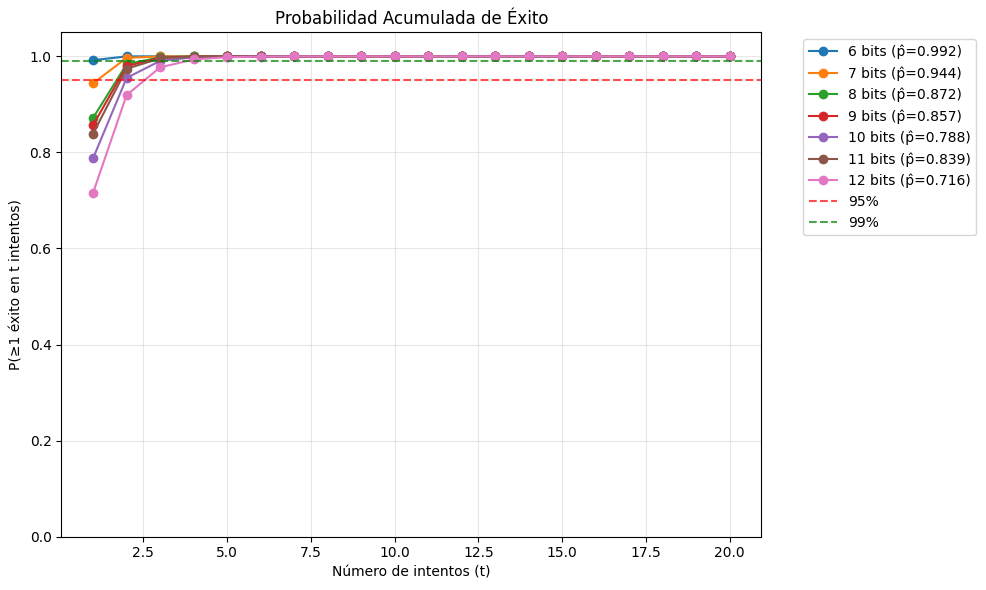

In [14]:
# Probabilidad acumulada
def plot_cumulative_probability(df: pd.DataFrame):
    """Gráfica de probabilidad acumulada."""
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_range = range(1, 21)
    
    for n_bits in sorted(df['n_bits'].unique()):
        p_hat = df[df['n_bits'] == n_bits]['success'].mean()
        if p_hat > 0:
            cum_prob = [1 - (1 - p_hat)**x for x in x_range]
            ax.plot(x_range, cum_prob, 'o-', label=f'{n_bits} bits (p̂={p_hat:.3f})')
    
    ax.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    ax.axhline(y=0.99, color='g', linestyle='--', alpha=0.7, label='99%')
    
    ax.set_xlabel('Número de intentos (t)')
    ax.set_ylabel('P(≥1 éxito en t intentos)')
    ax.set_title('Probabilidad Acumulada de Éxito')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/cumulative_probability.png", dpi=150)
    plt.show()

plot_cumulative_probability(df_results)

## Visualizaciones y Campana de Gauss

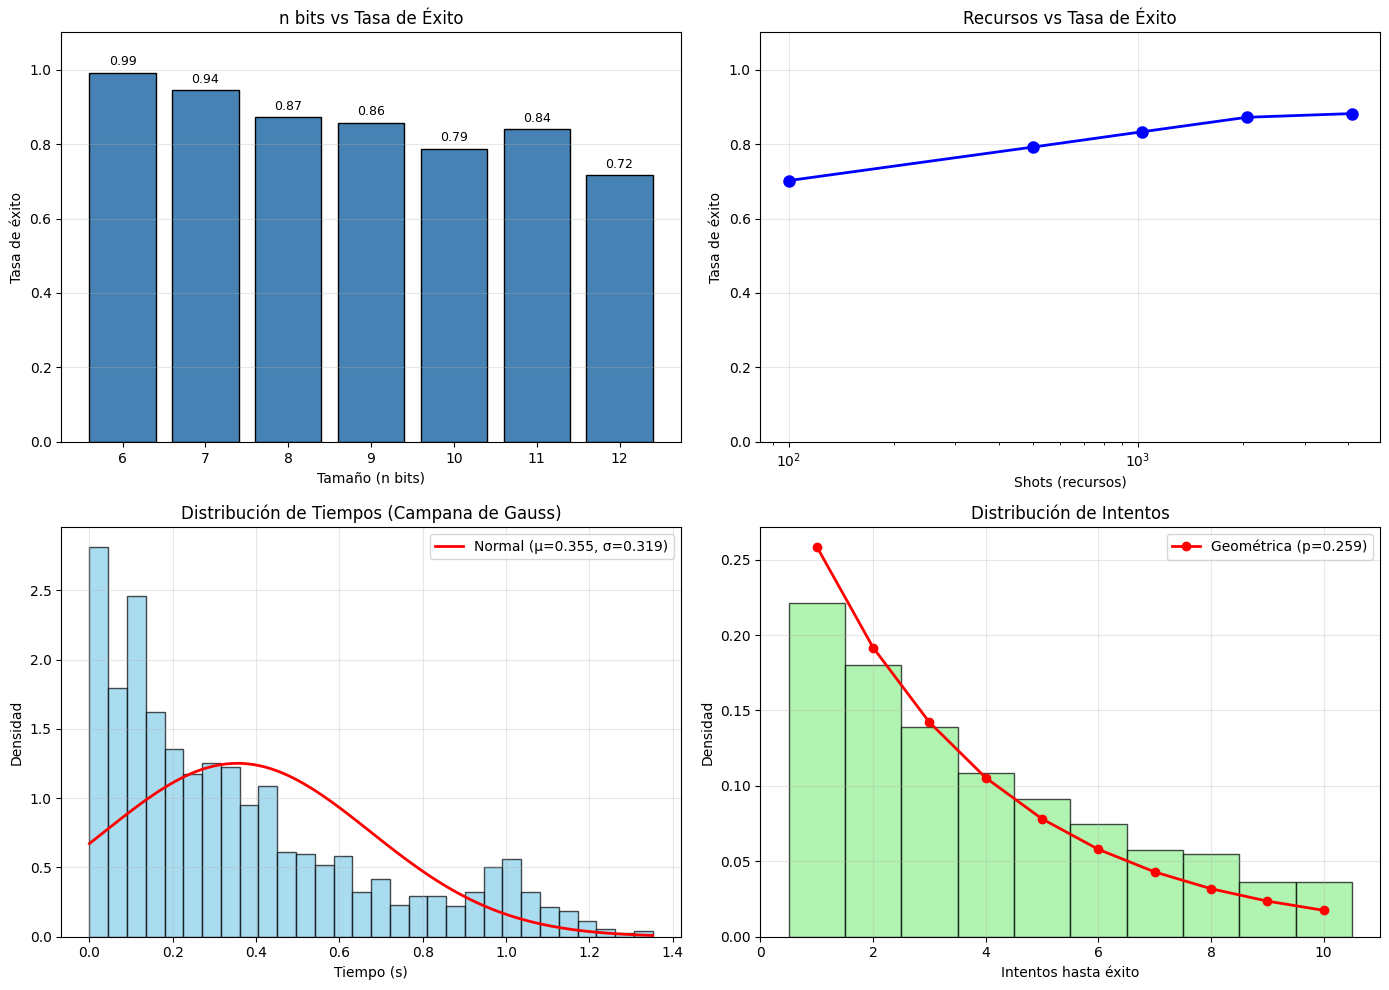

In [15]:
def analyze_distribution(df: pd.DataFrame):
    """Distribuciones y campana de Gauss."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Tasa de éxito por n_bits
    ax = axes[0, 0]
    by_bits = df.groupby('n_bits')['success'].mean()
    bars = ax.bar(by_bits.index, by_bits.values, color='steelblue', edgecolor='black')
    ax.set_xlabel('Tamaño (n bits)')
    ax.set_ylabel('Tasa de éxito')
    ax.set_title('n bits vs Tasa de Éxito')
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')
    for bar, rate in zip(bars, by_bits.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{rate:.2f}', ha='center', fontsize=9)
    
    # 2. Recursos (shots) vs Tasa de éxito
    ax = axes[0, 1]
    by_shots = df.groupby('M_shots')['success'].mean()
    ax.plot(by_shots.index, by_shots.values, 'bo-', linewidth=2, markersize=8)
    ax.set_xlabel('Shots (recursos)')
    ax.set_ylabel('Tasa de éxito')
    ax.set_title('Recursos vs Tasa de Éxito')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    # 3. Distribución de tiempos (Campana de Gauss)
    ax = axes[1, 0]
    times = df['time_sec'].values
    times = times[times < np.percentile(times, 99)]  # Quitar outliers
    
    ax.hist(times, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    
    mu, std = norm.fit(times)
    x = np.linspace(times.min(), times.max(), 100)
    ax.plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2,
            label=f'Normal (μ={mu:.3f}, σ={std:.3f})')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Densidad')
    ax.set_title('Distribución de Tiempos (Campana de Gauss)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Histograma de intentos
    ax = axes[1, 1]
    success_df = df[df['success'] == 1]
    if len(success_df) > 0:
        attempts = success_df['attempts'].values
        ax.hist(attempts, bins=range(1, 12), density=True, alpha=0.7,
                color='lightgreen', edgecolor='black', align='left')
        
        p_est = 1 / attempts.mean() if len(attempts) > 0 else 0.5
        x = np.arange(1, 11)
        geom_pmf = (1 - p_est)**(x-1) * p_est
        ax.plot(x, geom_pmf, 'r-o', linewidth=2, label=f'Geométrica (p={p_est:.3f})')
        ax.legend()
    
    ax.set_xlabel('Intentos hasta éxito')
    ax.set_ylabel('Densidad')
    ax.set_title('Distribución de Intentos')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/analysis_plots.png", dpi=150)
    plt.show()

analyze_distribution(df_results)

## Límites de Simulación Clásica

In [16]:
def analyze_classical_limits():
    """Analiza hasta cuántos bits puede manejar un PC."""
    
    print("\n" + "="*70)
    print("LÍMITES DE SIMULACIÓN CUÁNTICA EN PC")
    print("="*70)
    print("\nRecursos necesarios para simular Shor:")
    
    results = []
    for n_bits in range(4, 26, 2):
        n_qubits = 2 * n_bits + 3
        memory_gb = (2 ** n_qubits) * 16 / (1024**3)
        feasible_16gb = memory_gb < 16
        feasible_32gb = memory_gb < 32
        
        status = '✓ OK' if feasible_16gb else ('~ Límite' if feasible_32gb else '✗ Imposible')
        
        results.append({
            'n_bits': n_bits,
            'qubits': n_qubits,
            'memory_gb': memory_gb,
            'status': status
        })
        
        print(f"  {n_bits:2d} bits → {n_qubits:2d} qubits → {memory_gb:10.2f} GB {status}")
    
    print("\n" + "-"*70)
    print("CONCLUSIONES:")
    print("-"*70)
    print("• PC con 16GB RAM: hasta ~10 bits")
    print("• PC con 32GB RAM: hasta ~12 bits")
    print("• Números mayores requieren hardware cuántico real")
    print("\nComparación: Un PC clásico factoriza 128 bits en segundos,")
    print("pero NO puede simular un circuito cuántico de esa escala.")
    
    return pd.DataFrame(results)

df_limits = analyze_classical_limits()


LÍMITES DE SIMULACIÓN CUÁNTICA EN PC

Recursos necesarios para simular Shor:
   4 bits → 11 qubits →       0.00 GB ✓ OK
   6 bits → 15 qubits →       0.00 GB ✓ OK
   8 bits → 19 qubits →       0.01 GB ✓ OK
  10 bits → 23 qubits →       0.12 GB ✓ OK
  12 bits → 27 qubits →       2.00 GB ✓ OK
  14 bits → 31 qubits →      32.00 GB ✗ Imposible
  16 bits → 35 qubits →     512.00 GB ✗ Imposible
  18 bits → 39 qubits →    8192.00 GB ✗ Imposible
  20 bits → 43 qubits →  131072.00 GB ✗ Imposible
  22 bits → 47 qubits → 2097152.00 GB ✗ Imposible
  24 bits → 51 qubits → 33554432.00 GB ✗ Imposible

----------------------------------------------------------------------
CONCLUSIONES:
----------------------------------------------------------------------
• PC con 16GB RAM: hasta ~10 bits
• PC con 32GB RAM: hasta ~12 bits
• Números mayores requieren hardware cuántico real

Comparación: Un PC clásico factoriza 128 bits en segundos,
pero NO puede simular un circuito cuántico de esa escala.


## Resumen Final

In [17]:
def final_summary(df: pd.DataFrame):
    """Resumen final del experimento."""
    
    print("\n" + "="*70)
    print("RESUMEN DEL EXPERIMENTO")
    print("="*70)
    
    print(f"\nDatos recolectados:")
    print(f"  Total de ejecuciones: {len(df)}")
    print(f"  Éxitos: {df['success'].sum()} ({df['success'].mean()*100:.1f}%)")
    print(f"  Fracasos: {len(df) - df['success'].sum()}")
    
    print(f"\nRango de bits probados: {df['n_bits'].min()} a {df['n_bits'].max()}")
    print(f"Shots probados: {sorted(df['M_shots'].unique())}")
    
    print(f"\nTiempos:")
    print(f"  Promedio: {df['time_sec'].mean():.4f}s")
    print(f"  Máximo: {df['time_sec'].max():.4f}s")
    
    print(f"\nArchivos generados:")
    print(f"  {DATA_DIR}/shor_experiment.csv")
    print(f"  {DATA_DIR}/analysis_plots.png")
    print(f"  {DATA_DIR}/cumulative_probability.png")

final_summary(df_results)


RESUMEN DEL EXPERIMENTO

Datos recolectados:
  Total de ejecuciones: 5500
  Éxitos: 4488 (81.6%)
  Fracasos: 1012

Rango de bits probados: 6 a 12
Shots probados: [np.int64(100), np.int64(500), np.int64(1024), np.int64(2048), np.int64(4096)]

Tiempos:
  Promedio: 0.3663s
  Máximo: 2.0207s

Archivos generados:
  datasets/shor_experiment.csv
  datasets/analysis_plots.png
  datasets/cumulative_probability.png
